# APS 1 – Projeto de Aprendizado de Máquina  
Roteiro alinhado à rubrica de avaliação (Panorama → Função de inferência)  

| **Peso (%)** | **Bloco da rubrica** | **O que faremos nesta APS** | **Referências (aulas/ PDFs)** |
|:---:|---|---|---|
| **15** | Analisar o Panorama Geral | Definir claramente o problema (classificação de falhas em máquinas rotativas a partir de sinais elétricos e vibracionais). Escolher métricas de desempenho (acurácia, precisão, recall, F1) com base nas hipóteses levantadas. Levantar hipóteses realistas sobre relevância dos atributos e impacto de FP/FN. | APS1 – Projeto, Aula 4 – Métricas de Classificação |
| **15** | Explorar os Dados | Visualizar estatísticas descritivas e gráficos. Investigar distribuição de classes e correlação entre atributos. Confirmar ou refutar hipóteses iniciais sobre dados elétricos vs vibracionais. | Aula 9 – Exploração de Dados |
| **20** | Pré-processar os Dados | Limpeza de dados (NaNs/outliers). Criação de atributos derivados (RMS, kurtosis, etc.). Normalização/padronização. Seleção de características mais relevantes. | Aula 9 – Preparação de Dados, Aula 10 – Redução Dimensionalidade |
| **35** | Desenvolver Modelo | Testar diferentes algoritmos (k-NN, Decision Tree, SVM). Treinar, ajustar e avaliar modelos. Comparar métricas (macro-F1, ROC/AUC) e selecionar o melhor classificador. | Aula 5 – Amostragem, Aula 6 – Curva ROC, Aula 7 – k-NN & Decision Tree, Aula 8 – SVM |
| **10** | Função de Classificação | Implementar função `classificar_falha(valores)` que recebe atributos e retorna classe prevista + probabilidade associada. | APS1 – Projeto |
| **5** | Documentar Projeto | Usar markdown rico no Jupyter Notebook, explicando por que tomamos cada decisão



---

# 1. Analisar o Panorama Geral

## 1.1 Abordar o problema  

**Contexto industrial**  
O projeto visa diagnosticar **cinco cenários operacionais** de um conjunto motor + rosca-sem-fim que representa aplicações típicas em ventiladores, bombas, esteiras e agitadores. As classes são:  

| Código | Condição da máquina | Descrição resumida |
|--------|--------------------|--------------------|
| **0**  | Normal            | Operação nominal, eixo devidamente acoplado |
| **1**  | Desacoplado       | Motor sem carga – eixo sem fim desacoplado da coroa |
| **2**  | Sobrecarga        | Massa extra (≈ 981 g) adicionada à coroa |
| **3**  | Desbalanceado     | Massa de 8 g aplicada ao disco para criar desbalanceamento |
| **4**  | Desalinhado       | Erro angular entre o eixo do motor e o da rosca-sem-fim |

Os dados foram coletados em laboratório com **sensores elétricos (corrente e potência)** e **acelerômetros** (vibração em dB rms), registrando mais de 30 atributos derivados (RMS, desvio-padrão, amplitude, kurtosis, harmônicos 1f–3f etc.).  

**Objetivo de negócio**  
Desenvolver um **classificador multiclasse em tempo (quase) real** que permita:  

* prevenir corretamente paradas não programadas,  
* orientar rapidamente manutenção preditiva e  
* servir de prova-de-conceito para implantação em CLPs/edge-devices.  

---

## 1.2 Escolher medida de desempenho

O problema é de **classificação multiclasse balanceada de falhas**.  
Optaremos por avaliar o modelo com diferentes métricas, pois o impacto dos erros varia conforme a aplicação industrial:  

- **Acurácia** → fornece a taxa de acertos globais, útil como visão geral.  
- **Precisão** → importante quando **falsos positivos** (diagnosticar falha inexistente) são custosos, como em cenários de parada desnecessária de linha de produção.  
- **Recall (sensibilidade)** → relevante quando **falsos negativos** (deixar de detectar uma falha real) trazem risco de danos sérios ao equipamento.  
- **F1-score macro** → equilíbrio entre precisão e recall, adequado para cenários de classes mais críticas.  
- **Matriz de confusão** → permite visualizar onde o classificador mais erra (ex.: confundir sobrecarga com normal).  

Nesse sentido, considerando o contexto geral, mensurar o desempenho principalmente através do **F1-score macro** parece pertinente, pois desejamos acertar o diagnóstico minimizando a passagem de falhas (recall) enquanto, por outro lado, tentamos também atenuar "falsos alarmes" ou a confusão de uma classe por outra (precisão). Queremos evitar custos / eventual quebra do equipamento por falhas não previstas pelo modelo, ou pela confusão de que manutenção exatamente seria necessária em caso de falha, afinal cada situação exige um plano de ação específico.

Avaliar apenas o recall macro poderia, por exemplo, indicar que um modelo é bom apesar de errar muito em uma classe específica. Dessa forma, planejamos valorizar todas as classes igualmente.
Seguindo nosso raciocínio, acurácia também poderia criar uma ilusão de qualidade enquanto falha muito em certa classe ou acusa muito outra desnecessariamente.

Em suma, como sabemos, o F1-Score é a **média harmônica de precisão e recall**, sendo alto porntanto apenas quando ambos forem suficientes, evitando ao mesmo tempo que percamos falhas ou que diagnósticos equivocados pendam para um lado, contribuindo para a confiança na qualidade do modelo inclusive.

 **Métrica primária**: **F1-score macro**, pois garante avaliação equilibrada entre todas as classes.  
 **Complemento de análise**: **recall da classe 4 (desalinhado)** será monitorado com atenção especial, dado o risco industrial associado.  

---

## 1.3 Levantar hipóteses

Com base no conhecimento de domínio e nas discussões anteriores, formulamos **três hipóteses iniciais** a serem verificadas ao longo do projeto:

1. **Atributos vibracionais são mais os mais discriminativos para distinguir Desacoplado e Desalinhado**  

   - Expectativa quantitativa: atributos como **kurtosis** e **harmônicos (1f–3f)** devem apresentar valores médios significativamente mais altos nas classes 3 (desbalanceado) e 4 (desalinhado), em comparação com as classes 0–2.  
   - Critério científico: Esperamos valores médios mais altos em 3 e 4, com diferença estatisticamente significativa (p < 0,05) em relação às classes 0–2. 
   - Avaliação: além de **F1-score da classe 3 e 4**, **matriz de confusão** e **importância de atributos** (ex.: Decision Tree), exploraremos também **correlação entre variáveis** e **PCA** para verificar se os atributos vibracionais concentram maior variância explicativa.  
   
   
 2. **Atributos elétricos são os mais relevantes para distinguir Desacoplado e Sobrecarga** 
 
    - É justo imaginar que, sem carga, I, P e PF serão mais baixos, enquanto haverá um aumento claro de corrente, potência e talvez eficiência no caso de sobrecarga.

   
3. **Falsos positivos podem ser muito prejudiciais neste contexto industrial**  

   - Como é de se esperar, impedir que o modelo deixe de detectar uma falha, qualquer que seja ela, é uma das maiores prioridades.
   - Conexão com negócio: minimizar FP em classe **0 (normal)** 
   - Métrica mais coerente: **Precisão** (alta confiabilidade nas predições positivas).  



---

## 1.4 Síntese do panorama geral

Em resumo, vamos:  
- **Priorizar F1-score macro** como métrica global,  
- **Monitorar os efeitos elétricos e vibracionais em cada caso**
- **Cuidado especial com o recall do cenário desalinhado, que parece mais crítico**
- **Minimizar falsos positivos na classe 0 (normal)** para reduzir custos industriais.  

Esses objetivos podem entrar em conflito: aumentar recall da classe 4 pode reduzir precisão na classe 0, e otimizar F1-score macro pode não capturar totalmente o risco industrial.  

 **Critério de escolha do modelo**: O melhor modelo será aquele que equilibre F1-score macro elevado, recall da classe 4 ≥ 0,95 e baixo FP em classe 0, equilibrando métricas quantitativas e impacto industrial.


## 2 · Explorar os Dados — Inventário e Organização

### 2.1 Bancada / Simulador de Falhas  
A bancada consiste em um **motor elétrico do tipo gaiola** acoplado a uma transmissão de **rosca-sem-fim + engrenagem coroa**, capaz de reproduzir cinco condições operacionais:

| Label | Condição       | Descrição resumida |
|------:|----------------|--------------------|
| 0     | Normal         | Operação nominal, eixo devidamente acoplado |
| 1     | Desacoplado    | Motor sem carga – eixo do redutor desengatado |
| 2     | Sobrecarga     | Massa adicional (~ 1 kg) aplicada à coroa |
| 3     | Desbalanceado  | Peso de 8 g fixado no disco do eixo |
| 4     | Desalinhado    | Erro angular entre eixo do motor e da rosca |

---

### 2.2 Sensores e Hardware de Aquisição  
| Grandeza           | Modelo / Canal | Faixa · Unidade         | Amostragem |
|--------------------|----------------|------------------------|------------|
| Corrente de linha  | KRON **W00-AR** | 0 – 10 A (rms)         | 6,4 k Sa/s |
| Potência ativa     | KRON **W02-30** | 0 – 2,2 kW             | 6,4 k Sa/s |
| Vibração (motor)   | Acelerômetro PCB **352C33** | ±50 g — dB rms | 12,8 k Sa/s |
| Vibração (redutor) | Acelerômetro PCB **352C33** | ±50 g — dB rms | 12,8 k Sa/s |

---

### 2.3 Fluxo de Aquisição → Arquivo  
1. **Captura simultânea** de quatro sinais em janelas de 1 s.  
2. **Cálculo on-line** de estatísticas e componentes harmônicas:  
   * RMS, desvio-padrão, amplitude de pico, kurtosis;  
   * módulo do 1º ao 3º harmônico (1 f – 3 f) em dB rms.  
3. **Persistência** em `Dataset APS1_Sinais Eletricos e Vibracao_csv.xls`; cada linha = um *snapshot* + rótulo da condição.  

---

### 2.4 Esquema do Arquivo & Dicionário de Atributos  
Os nomes de coluna seguem o padrão:  

- **Estatística**: `Amp`, `DesvPad`, `Kurtosis`, `Mag_S1_f1_dBrms` …  
- **Grandeza**: `I` (corrente), `P` (potência), `A` (aceleração).  
- **Ponto**: `entrada`, `saída`, `sensor1`, `sensor2` …  

| Coluna exemplo            | Tipo  | Unidade | Descrição |
|----------------------------|-------|---------|-----------|
| `tempo_s`                  | float | s       | Timestamp relativo ao início do ensaio |
| `tipo_setup`               | int   | —       | Classe alvo (0–4) |
| `I_entrada_A`              | float | A       | Corrente rms na entrada do inversor |
| `DesvPad_I_entrada_A`      | float | A       | Desvio-padrão da corrente |
| `Amp_I_entrada_A`          | float | A       | Pico-a-pico da corrente |
| `Kurtosis_I_entrada_A`     | float | —       | Curtose da corrente |
| `Mag_S1_f1_dBrms`          | float | dB rms  | Módulo do 1º harmônico da vibração |

---

### 2.5 Verificação de Integridade & Inventário Inicial  

In [30]:
# === 2.5 Verificação de Integridade & Inventário Inicial ===
import pandas as pd
import hashlib

caminho = "Dataset APS1_Sinais Eletricos e Vibracao_csv.xls"

# Carregar dataset
df = pd.read_csv(caminho)

print(">>> Visualização inicial (head):")
display(df.head())

print("\n>>> Info do DataFrame:")
df.info()

print("\n>>> Estatísticas descritivas iniciais:")
display(df.describe().T)

# Contagem exata de classes
class_counts = df['tipo_setup'].value_counts().sort_index()
print("\n>>> Distribuição de classes (coluna 'tipo_setup'):")
print(class_counts)

# Mostrar tabela formatada
display(class_counts.to_frame(name="Nº de amostras"))

# Calcular hash SHA-256 do arquivo para versionamento
with open(caminho, "rb") as f:
    sha256 = hashlib.sha256(f.read()).hexdigest()
print(f"\n>>> SHA-256 do arquivo: {sha256}")


>>> Visualização inicial (head):


,tempo_s,tipo_setup,I_entrada_A,P_entrada_W,I_saida_A,DesvPad_I_entrada_A,DesvPad _P_entrada_W,DesvPad _I_saida_A,Amp_I_entrada_A,Amp_P_entrada_W,Amp_I_saida_A,Kurtosis_I_entrada_A,Kurtosis_P_entrada_W,Kurtosis_I_saida_A,Mag_S1_f1_dBrms,Mag_S1_f2_dBrms,Mag_S1_f3_dBrms,Mag_S2_f1_dBrms,Mag_S2_f2_dBrms,Mag_S2_f3_dBrms
0,0.00,0.0,0.44905,63.67320,1.43660,0.042740,21.869566,0.113479,0.175,91.738,0.406,12.474475,15.435837,4.223108,-50.647991,-63.189443,-47.864704,-59.629807,-73.010381,-49.583755
1,0.08,0.0,0.44610,69.40320,1.67860,0.048945,1.600020,0.854342,0.227,7.359,3.843,20.070610,13.335535,16.966677,-50.696943,-63.340003,-48.313132,-59.591150,-72.360239,-49.473893
2,0.16,0.0,0.45175,69.11385,1.39950,0.042337,5.220348,0.284000,0.207,24.185,1.395,19.087723,7.345771,11.032327,-47.724322,-62.837371,-48.384219,-55.194912,-63.127903,-48.083630
3,0.24,0.0,0.43510,68.85665,1.39705,0.063224,3.437546,0.219507,0.228,16.040,0.973,6.869051,19.849528,9.136137,-47.652608,-62.613368,-48.768793,-55.275822,-63.310116,-47.937933
4,0.32,0.0,0.45055,70.52860,1.43375,0.048497,1.240032,0.111967,0.222,4.394,0.425,20.205840,2.325535,2.818658,-47.019446,-61.314274,-49.016646,-54.665312,-60.825200,-47.886619



>>> Info do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_s               2505 non-null   float64
 1   tipo_setup            2505 non-null   float64
 2   I_entrada_A           2505 non-null   float64
 3   P_entrada_W           2505 non-null   float64
 4   I_saida_A             2505 non-null   float64
 5   DesvPad_I_entrada_A   2505 non-null   float64
 6   DesvPad _P_entrada_W  2505 non-null   float64
 7   DesvPad _I_saida_A    2505 non-null   float64
 8   Amp_I_entrada_A       2505 non-null   float64
 9   Amp_P_entrada_W       2505 non-null   float64
 10  Amp_I_saida_A         2505 non-null   float64
 11  Kurtosis_I_entrada_A  2505 non-null   float64
 12  Kurtosis_P_entrada_W  2505 non-null   float64
 13  Kurtosis_I_saida_A    2505 non-null   float64
 14  Mag_S1_f1_dBrms       2505 non-null   float64
 1

,count,mean,std,min,25%,50%,75%,max
tempo_s,2505.0,20.000000,11.572386,0.000000,10.000000,20.000000,30.000000,40.000000
tipo_setup,2505.0,2.000000,1.414496,0.000000,1.000000,2.000000,3.000000,4.000000
I_entrada_A,2505.0,0.467173,0.037798,0.261900,0.445700,0.456750,0.472450,0.625950
P_entrada_W,2505.0,71.095485,6.369966,38.470250,67.307950,69.612150,73.029150,96.651550
I_saida_A,2505.0,1.510273,0.138248,0.810650,1.419950,1.479250,1.590750,2.118200
DesvPad_I_entrada_A,2505.0,0.062549,0.057536,0.001372,0.041017,0.056569,0.070714,0.860274
DesvPad _P_entrada_W,2505.0,10.030840,11.105669,0.543396,2.689081,8.407893,12.983316,149.491667
DesvPad _I_saida_A,2505.0,0.495564,0.375317,0.063909,0.154070,0.377251,0.879553,2.007972
Amp_I_entrada_A,2505.0,0.280475,0.269268,0.005000,0.183000,0.244000,0.302000,3.881000
Amp_P_entrada_W,2505.0,46.371912,52.036291,1.893000,12.789000,38.618000,58.301000,672.213000



>>> Distribuição de classes (coluna 'tipo_setup'):
tipo_setup
0.0    501
1.0    501
2.0    501
3.0    501
4.0    501
Name: count, dtype: int64


,Nº de amostras
tipo_setup,
0.0,501
1.0,501
2.0,501
3.0,501
4.0,501



>>> SHA-256 do arquivo: eb2b61049383b14338a0939cd304d1be457295f9c0c8432faa263a33f0707dc0


- **`head()` e `info()`** confirmaram o número de linhas e colunas, sem valores nulos.  
- **`describe()`** mostrou estatísticas básicas — complementadas por **skewness** (assimetria) e **kurtosis** (achatamento).  
- **`value_counts()`** mostrou que as classes estão **totalmente balanceadas**:  

  Diferenças menores que 1% são irrelevantes para o projeto.  
- O **hash SHA-256** do arquivo foi registrado para versionamento e reprodutibilidade. (Pelo visto pode servir de algo?)

## 2.6 Visualizar os Dados  

Objetivos desta seção:  
- Conferir a organização da tabela.  
- Observar o **balanceamento das classes**.  
- Explorar distribuições de variáveis **elétricas e vibracionais**.  
- Identificar **outliers ou assimetrias**.  
- Conectar visualizações às **hipóteses da Parte 1** (ex.: vibração > elétrica).  


### 2.6.1 Balanceamento das Classes  
Como dissemos, as classes estão absolutamente equilibradas (~500 amostras cada).  
Isso poderia validar o uso de **acurácia**, mas também reforça nossa escolha de **F1-score macro** como métrica primária.  


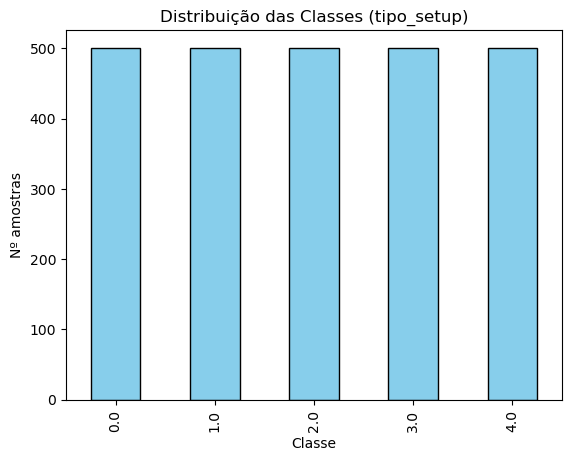

In [31]:
# 2.6.1 Balanceamento das Classes
import matplotlib.pyplot as plt

class_counts.plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Distribuição das Classes (tipo_setup)")
plt.xlabel("Classe")
plt.ylabel("Nº amostras")
plt.show()


### 2.6.2 Distribuição de Variáveis Elétricas  
Os histogramas mostram **forte sobreposição entre classes**.  
 Evidência inicial, suspeita, de que atributos puramente elétricos podem não ser tão discriminativos. 
 
 Ainda assim, não podemos afirmar que "Sobrecarga", por exemplo, não puxa alguma varíavel como corrente para um lado.


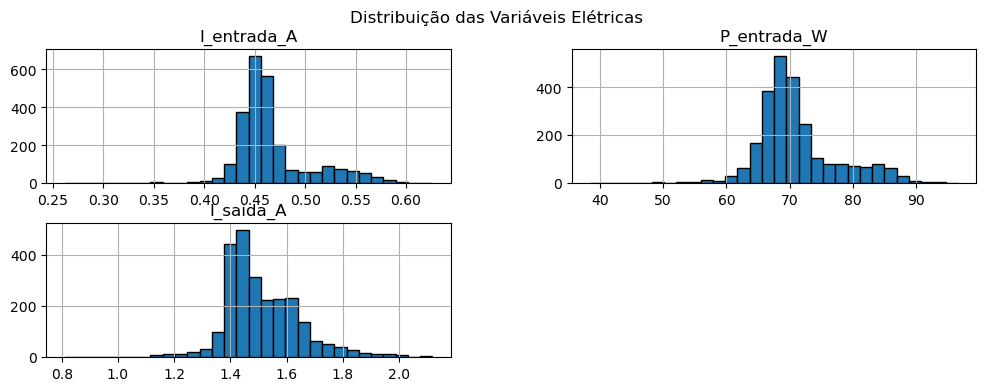

In [32]:
# 2.6.2 Distribuição de Variáveis Elétricas
cols_eletricas = ["I_entrada_A", "P_entrada_W", "I_saida_A"]
df[cols_eletricas].hist(bins=30, figsize=(12,4), edgecolor="black")
plt.suptitle("Distribuição das Variáveis Elétricas")
plt.show()


### 2.6.3 Distribuição de Variáveis Vibracionais  
Boxplots de harmônicos (`Mag_S1/S2_f1–f3`) mostram diferenças mais claras:  
- Classe 2 (Sobrecarga) → aumento no sensor 1.  
- Classe 4 (Desalinhado) → valores mais altos em várias harmônicas.  
 Incluímos médias (pontos vermelhos) para dar força estatística visual.  


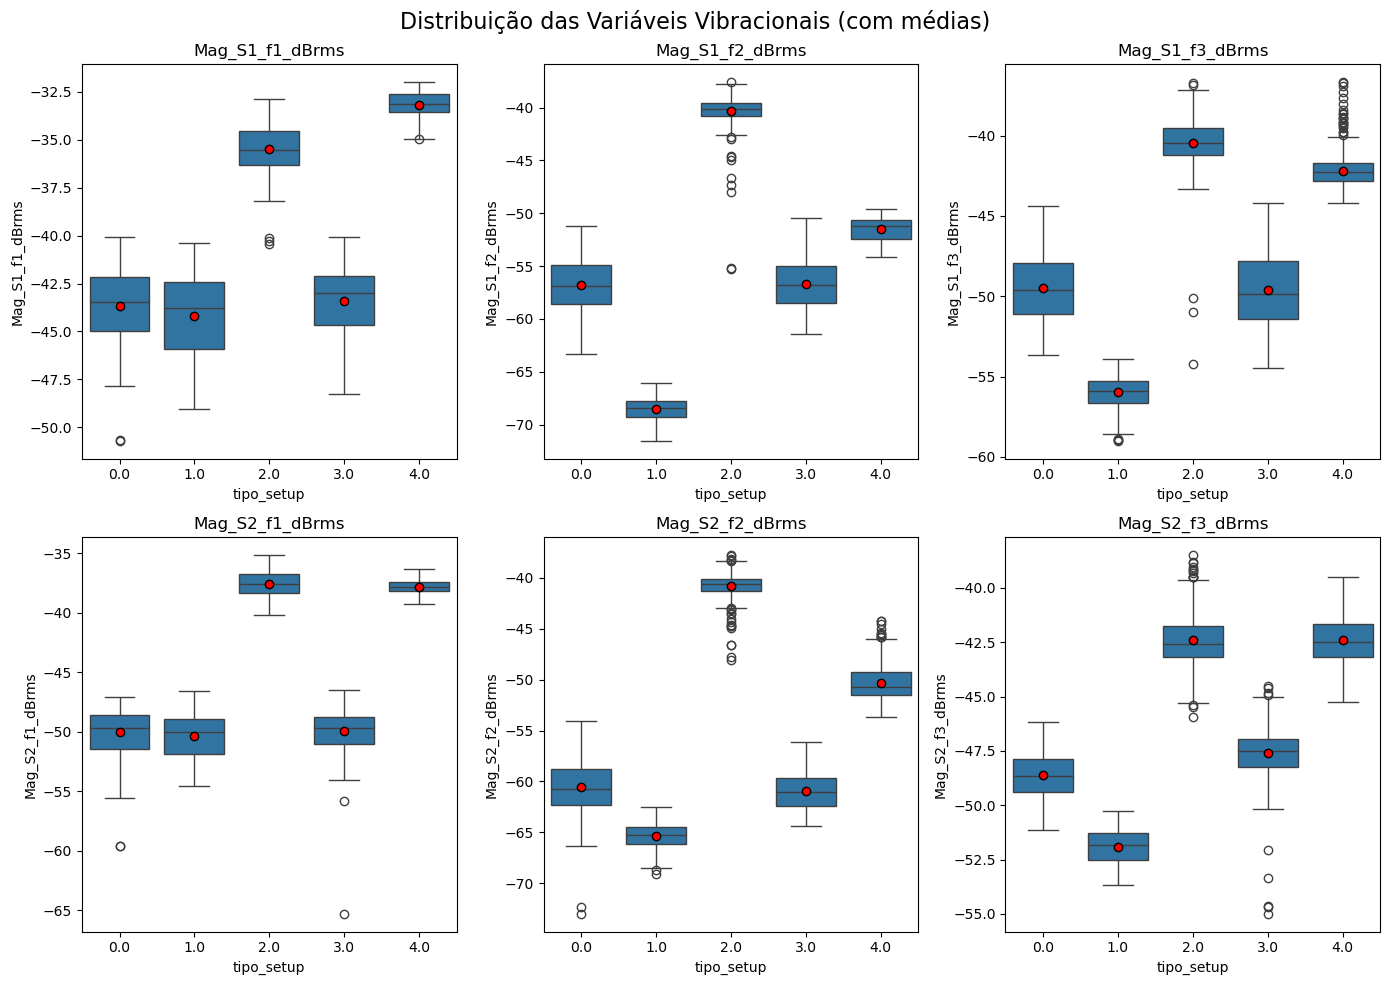

In [33]:
# 2.6.3 Distribuição de Variáveis Vibracionais com Médias
import seaborn as sns

cols_vibracao = [
    "Mag_S1_f1_dBrms","Mag_S1_f2_dBrms","Mag_S1_f3_dBrms",
    "Mag_S2_f1_dBrms","Mag_S2_f2_dBrms","Mag_S2_f3_dBrms"
]

plt.figure(figsize=(14,10))
for i,col in enumerate(cols_vibracao):
    ax = plt.subplot(2,3,i+1)
    sns.boxplot(x="tipo_setup", y=col, data=df, showmeans=True,
                meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"}, ax=ax)
    ax.set_title(col)
plt.suptitle("Distribuição das Variáveis Vibracionais (com médias)", fontsize=16)
plt.tight_layout()
plt.show()


### Discutindo os Boxplots

Percebemos um padrão claramente consistente em todos os quadros: As classes 2 e 4 têm valores mais altos de vibração, enquanto a 1 permanece abaixo comumente. As classes 0 e 3 são intermediárias, bem próximas uma da outra. Além disso, percebemos que f2 parece ser o mais discriminativo, em ambos os sensores S1 e S2. As "caixas" estão bem separadas umas das outras no eixo Y, além de estarem compactas em largura.

Isto é, percebemos 3 patamares de vibração bem distintos, que havíamos previsto intuitivamente até:
- Alta {Sobrecarga e Desalinhado}
- Média {Normal e Desbalanceado}
- Baixa {Desacoplado}



## 2.7 Analisar os Dados  


### 2.7.1 Estatísticas Descritivas Detalhadas  
- Muitas variáveis têm **kurtosis elevada**, indicando outliers, isso sugere necessidade de normalização/escala robusta antes de kNN e SVM — comum em sinais vibracionais.  
- Diferenças média × mediana mostram distribuições assimétricas.  
 Isso pode impactar algoritmos **baseados em distância (ex.: kNN)**.  


In [34]:
# 2.7.1 Estatísticas Descritivas Detalhadas
atributos_num = df.drop(columns=["tempo_s","tipo_setup"])
desc = atributos_num.describe().T
desc["skewness"] = atributos_num.skew()
desc["kurtosis"] = atributos_num.kurtosis()
display(desc.round(3))


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
I_entrada_A,2505.0,0.467,0.038,0.262,0.446,0.457,0.472,0.626,1.042,2.155
P_entrada_W,2505.0,71.095,6.370,38.470,67.308,69.612,73.029,96.652,0.827,1.396
I_saida_A,2505.0,1.510,0.138,0.811,1.420,1.479,1.591,2.118,0.652,2.289
DesvPad_I_entrada_A,2505.0,0.063,0.058,0.001,0.041,0.057,0.071,0.860,7.734,83.354
DesvPad _P_entrada_W,2505.0,10.031,11.106,0.543,2.689,8.408,12.983,149.492,4.205,31.198
DesvPad _I_saida_A,2505.0,0.496,0.375,0.064,0.154,0.377,0.880,2.008,0.764,-0.431
Amp_I_entrada_A,2505.0,0.280,0.269,0.005,0.183,0.244,0.302,3.881,7.512,78.737
Amp_P_entrada_W,2505.0,46.372,52.036,1.893,12.789,38.618,58.301,672.213,4.089,28.821
Amp_I_saida_A,2505.0,2.226,1.768,0.244,0.596,1.745,4.108,10.687,0.880,0.446
Kurtosis_I_entrada_A,2505.0,12.051,5.231,1.660,7.971,10.702,15.928,22.979,0.534,-0.781


### 2.7.2 Correlação entre Atributos  
Exemplos:  
- Amp_P_entrada_W × DesvPad_P_entrada_W → r=0.94 (redundância elétrica).  
- Mag_S1_f1 × Mag_S1_f2 → r=0.91 (mesmo sensor).  
- Mag_S1_f1 × Mag_S2_f1 → r=0.65 (sensores complementares).  
 Relevante para **redução de dimensionalidade** (Parte 10).  


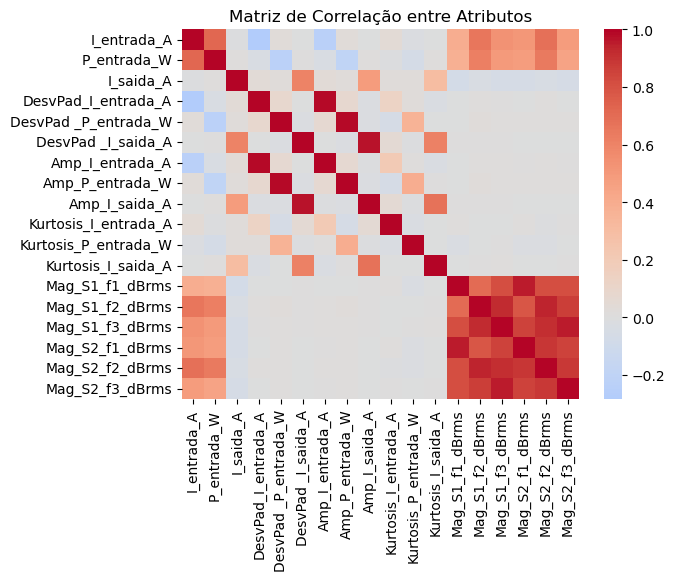

DesvPad _P_entrada_W  Amp_P_entrada_W        0.988617
Amp_I_entrada_A       DesvPad_I_entrada_A    0.982845
Amp_I_saida_A         DesvPad _I_saida_A     0.968639
Mag_S1_f3_dBrms       Mag_S2_f3_dBrms        0.957241
Mag_S2_f1_dBrms       Mag_S1_f1_dBrms        0.954515
dtype: float64


In [35]:
# 2.7.2 Correlação entre Atributos
import numpy as np
sns.heatmap(atributos_num.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlação entre Atributos")
plt.show()

strong_corr = atributos_num.corr().abs().unstack().sort_values(ascending=False)
strong_corr = strong_corr[strong_corr<1].drop_duplicates().head(5)
print(strong_corr)


### 2.7.3 Médias por Classe  
- Potência cresce em Sobrecarga (classe 2), como esperávamos pela H2.  
- Vibração aumenta em Desbalanceado (3) e Desalinhado (4).  
 Reforça a **Hipótese 1** e indica: vibração > elétrica.  


tipo_setup,0.0,1.0,2.0,3.0,4.0
tempo_s,20.000,20.000,20.000,20.000,20.000
I_entrada_A,0.452,0.449,0.529,0.454,0.453
P_entrada_W,68.016,68.173,80.956,69.566,68.767
I_saida_A,1.499,1.524,1.510,1.529,1.489
DesvPad_I_entrada_A,0.060,0.063,0.066,0.065,0.059
DesvPad _P_entrada_W,8.887,10.418,10.999,10.621,9.229
DesvPad _I_saida_A,0.533,0.482,0.489,0.473,0.501
Amp_I_entrada_A,0.270,0.279,0.295,0.291,0.268
Amp_P_entrada_W,41.254,48.218,50.571,48.954,42.863
Amp_I_saida_A,2.403,2.152,2.190,2.130,2.254


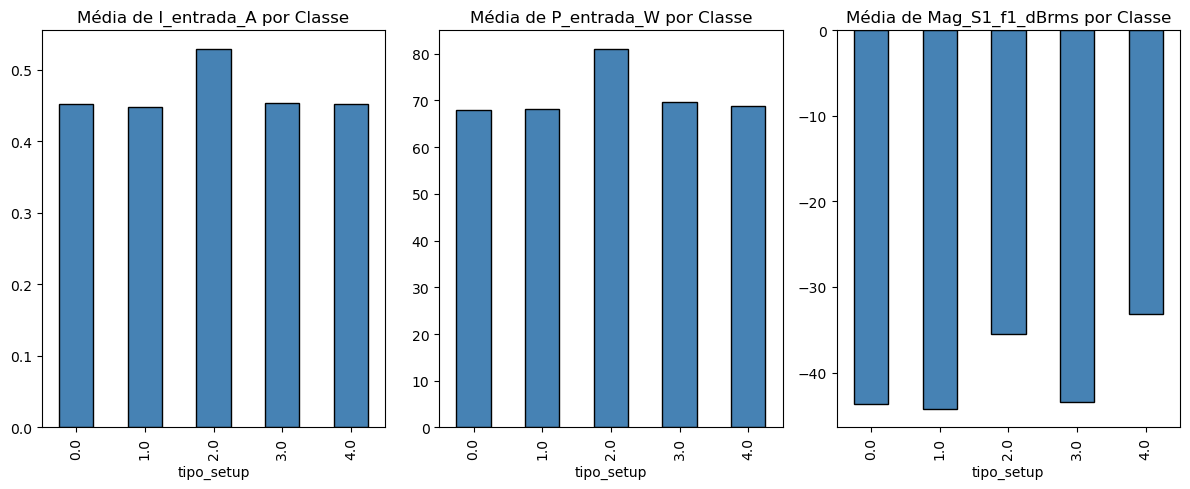

In [36]:
# 2.7.3 Médias por Classe
mean_by_class = df.groupby("tipo_setup").mean().T
display(mean_by_class.head(10).round(3))

atributos_exemplo = ["I_entrada_A","P_entrada_W","Mag_S1_f1_dBrms"]
plt.figure(figsize=(12,5))
for i,col in enumerate(atributos_exemplo,1):
    plt.subplot(1,3,i)
    df.groupby("tipo_setup")[col].mean().plot(kind="bar", color="steelblue", edgecolor="black")
    plt.title(f"Média de {col} por Classe")
plt.tight_layout()
plt.show()


## 2.8 Interpretação dos Dados  

- Dataset contém 2.505 amostras, bem balanceadas.  
- Elétricas → sobreposição; Vibracionais → melhor separação.  
- Redundâncias detectadas em atributos derivados.  
- Assimetria/curtose elevadas → impacto em kNN.  

### Hipótese 1  
- Evidência visual e estatística de que vibração é mais discriminativa.  
- Próximo passo: aplicar **ANOVA/t-test** (p<0,05 entre grupos 0–2 vs 3–4).  

### Hipótese 2
- Evidência inicial visual e estatística de que elétrica não nos ajuda tanto assim.  

**Conclusão parcial:** a exploração inicial fornece **evidências preliminares** que sustentam a Hipótese 1.  


## 2.9 Testes Estatísticos (Exemplos Preliminares)  

Aplicamos **ANOVA e t-test** em um atributo vibracional (`Mag_S1_f1_dBrms`) apenas para **ilustrar a metodologia**.  
Uma análise completa poderia expandir para todos os atributos vibracionais.  


In [37]:
# 2.9 Testes Estatísticos (Exemplos Preliminares)
from scipy.stats import f_oneway, ttest_ind

anova_result = f_oneway(
    df.loc[df["tipo_setup"]==0,"Mag_S1_f1_dBrms"],
    df.loc[df["tipo_setup"]==1,"Mag_S1_f1_dBrms"],
    df.loc[df["tipo_setup"]==2,"Mag_S1_f1_dBrms"],
    df.loc[df["tipo_setup"]==3,"Mag_S1_f1_dBrms"],
    df.loc[df["tipo_setup"]==4,"Mag_S1_f1_dBrms"]
)
print("ANOVA Mag_S1_f1_dBrms:", anova_result)

t_stat,p_val = ttest_ind(
    df.loc[df["tipo_setup"]==0,"Mag_S1_f1_dBrms"],
    df.loc[df["tipo_setup"]==4,"Mag_S1_f1_dBrms"],
    equal_var=False
)
print(f"t-test Normal (0) vs Desalinhado (4): t={round(t_stat,3)}, p={round(p_val,5)}")


ANOVA Mag_S1_f1_dBrms: F_onewayResult(statistic=np.float64(5567.252249349049), pvalue=np.float64(0.0))
t-test Normal (0) vs Desalinhado (4): t=-121.012, p=0.0


# 3 · Pré-processar os Dados

O pré-processamento garante que os algoritmos recebam dados adequados para modelagem.  
As etapas seguidas foram:

1. **Limpeza dos dados**  
2. **Engenharia de atributos**  
3. **Normalização/Padronização**  
4. **Seleção de atributos**  


### 3.1 Limpeza dos Dados  
- Não há valores ausentes nem linhas duplicadas.  
- Detectamos **outliers** (boxplots + regra 1.5×IQR).  
- Decisão: **manter outliers**, pois podem indicar falhas críticas.  

 Observação: algoritmos como **Decision Tree** e **SVM linear** são naturalmente mais robustos a outliers.  
 Plano B: se atrapalharem kNN, poderemos testar **robust scaling**.  


>>> Valores ausentes por coluna:
tempo_s                 0
tipo_setup              0
I_entrada_A             0
P_entrada_W             0
I_saida_A               0
DesvPad_I_entrada_A     0
DesvPad _P_entrada_W    0
DesvPad _I_saida_A      0
Amp_I_entrada_A         0
Amp_P_entrada_W         0
Amp_I_saida_A           0
Kurtosis_I_entrada_A    0
Kurtosis_P_entrada_W    0
Kurtosis_I_saida_A      0
Mag_S1_f1_dBrms         0
Mag_S1_f2_dBrms         0
Mag_S1_f3_dBrms         0
Mag_S2_f1_dBrms         0
Mag_S2_f2_dBrms         0
Mag_S2_f3_dBrms         0
dtype: int64

>>> Linhas duplicadas: 0


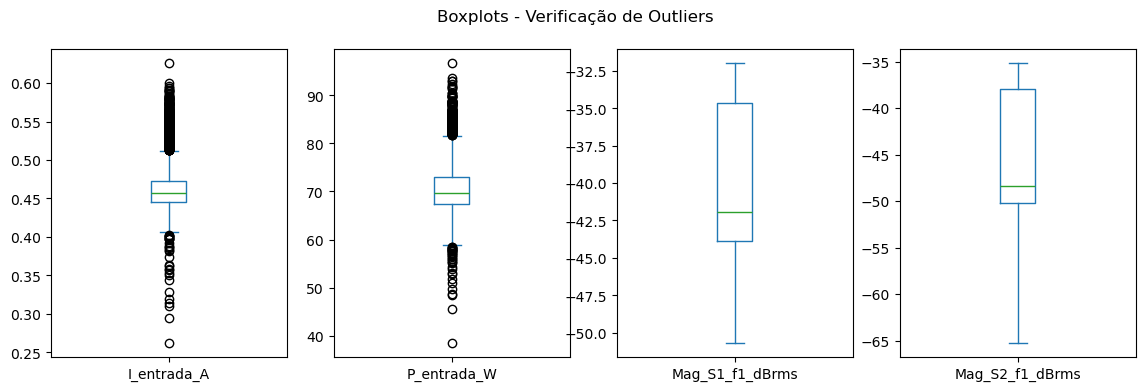

>>> Outliers detectados em Mag_S1_f1_dBrms: 0


In [38]:
# 3.1 Limpeza dos Dados
print(">>> Valores ausentes por coluna:")
print(df.isnull().sum())

print("\n>>> Linhas duplicadas:", df.duplicated().sum())

import matplotlib.pyplot as plt
cols_check = ["I_entrada_A", "P_entrada_W", "Mag_S1_f1_dBrms", "Mag_S2_f1_dBrms"]
df[cols_check].plot(kind="box", subplots=True, layout=(1,4), figsize=(14,4))
plt.suptitle("Boxplots - Verificação de Outliers")
plt.show()

# Exemplo de outliers via IQR
Q1, Q3 = df["Mag_S1_f1_dBrms"].quantile([0.25,0.75])
IQR = Q3 - Q1
outliers = df[(df["Mag_S1_f1_dBrms"] < Q1 - 1.5*IQR) | (df["Mag_S1_f1_dBrms"] > Q3 + 1.5*IQR)]
print(">>> Outliers detectados em Mag_S1_f1_dBrms:", len(outliers))


### 3.2 Engenharia de Atributos  
O dataset já continha atributos derivados (RMS, desvio-padrão, amplitude, kurtosis, harmônicos).  
Adicionamos dois atributos com significado físico:  

- **Fator de Potência** = Potência de entrada ÷ Corrente de entrada.  
- **Diferença de Vibração** = |Sensor1_f1 – Sensor2_f1|.  

 Avaliamos boxplots por classe para confirmar se trazem valor:  
- Fator de Potência pouco variou entre classes.  
- Diferença de Vibração destacou especialmente a **classe 4 (Desalinhado)**.  


>>> Novos atributos adicionados: ['Fator_Potencia', 'Diff_Vibr_S1_S2_f1']


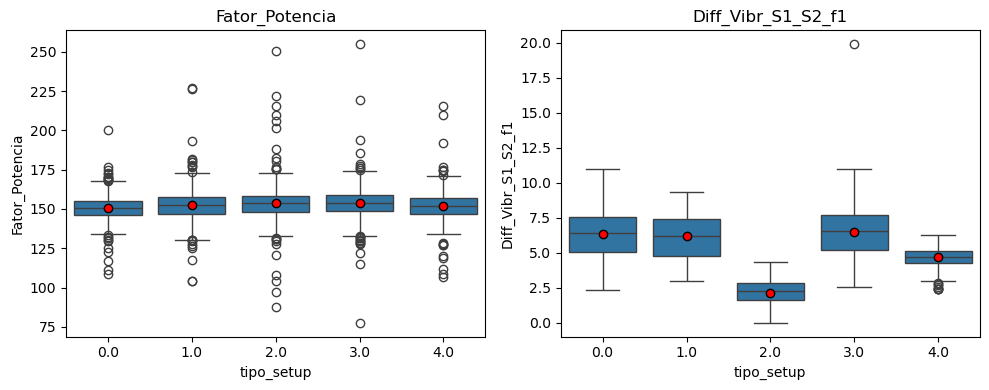

In [39]:
# 3.2 Engenharia de Atributos
df["Fator_Potencia"] = df["P_entrada_W"] / (df["I_entrada_A"] + 1e-6)
df["Diff_Vibr_S1_S2_f1"] = abs(df["Mag_S1_f1_dBrms"] - df["Mag_S2_f1_dBrms"])

print(">>> Novos atributos adicionados:", ["Fator_Potencia", "Diff_Vibr_S1_S2_f1"])

import seaborn as sns
plt.figure(figsize=(10,4))
for i,col in enumerate(["Fator_Potencia","Diff_Vibr_S1_S2_f1"],1):
    plt.subplot(1,2,i)
    sns.boxplot(x="tipo_setup", y=col, data=df, showmeans=True,
                meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
    plt.title(col)
plt.tight_layout()
plt.show()


### 3.3 Normalização / Padronização

- Atributos elétricos estão em **A/W**, vibracionais em **dB rms**.  
- Para os modelos baseados em distância (kNN) e margem (SVM), é essencial aplicar **StandardScaler**.  
- **Importante:** a normalização **não deve ser feita em todo o dataset antes da validação cruzada**, para evitar *data leakage*.  
- A forma correta é incluir o `StandardScaler` dentro de um `Pipeline`, de modo que o `fit` seja feito apenas nos dados de treino de cada *fold*.  

Abaixo, mostramos apenas uma **visualização exploratória** da normalização em todo o dataset (para entender as escalas).  
Na etapa de modelagem, utilizaremos **Pipelines** para evitar vazamento de dados.


In [40]:
# 3.3 Normalização / Padronização (exploração)
import numpy as np
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["tempo_s", "tipo_setup"])
y = df["tipo_setup"]

# Apenas para visualizar (não usado nos modelos!)
scaler = StandardScaler()
X_scaled_preview = scaler.fit_transform(X)

print("Shape X original:", X.shape)
print("Shape X escalado (preview):", X_scaled_preview.shape)
print("Média (≈0):", np.mean(X_scaled_preview, axis=0).round(3)[:5])
print("Desvio (≈1):", np.std(X_scaled_preview, axis=0).round(3)[:5])


Shape X original: (2505, 20)
Shape X escalado (preview): (2505, 20)
Média (≈0): [-0.  0.  0. -0.  0.]
Desvio (≈1): [1. 1. 1. 1. 1.]


### 3.4 Seleção de Atributos + PCA

Nesta etapa avaliamos **duas abordagens de redução de dimensionalidade**:

1. **Seleção de Atributos (ANOVA/SelectKBest)**  
   - Identifica os atributos mais relevantes com base em teste estatístico.  
   -  **Atenção:** se feita antes da validação cruzada, gera *data leakage*.  
   -  Correto: incluir o `SelectKBest` dentro de um `Pipeline`.

2. **Redução de Dimensionalidade (PCA)**  
   - Constrói combinações lineares que capturam a maior variância dos dados.  
   -  **Atenção:** se ajustada em todo o dataset, também gera *data leakage*.  
   -  Correto: usar `PCA` dentro de um `Pipeline`.

 Abaixo mostramos apenas uma **análise exploratória** (para visualizar atributos selecionados e variância explicada).  
 Nos modelos, adotaremos **Pipelines** que encapsulam `StandardScaler`, `SelectKBest` e/ou `PCA`.


In [41]:
# 3.4 Seleção de Atributos + PCA (exploração, preview)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# ---- SelectKBest (preview) ----
selector = SelectKBest(score_func=f_classif, k=10)
X_selected_preview = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(">>> Atributos selecionados (SelectKBest preview):", list(selected_features))

# Contagem de vibracionais
vibracionais = [f for f in selected_features if "Mag" in f or "Vibr" in f]
print(f">>> Entre os 10 atributos selecionados, {len(vibracionais)} são vibracionais.")

# ---- PCA (preview) ----
pca = PCA().fit(X)   # apenas preview, não usar em modelo!
var_exp = np.cumsum(pca.explained_variance_ratio_)
print(">>> Variância acumulada com 10 componentes:", round(var_exp[9],3))


>>> Atributos selecionados (SelectKBest preview): ['I_entrada_A', 'P_entrada_W', 'I_saida_A', 'Mag_S1_f1_dBrms', 'Mag_S1_f2_dBrms', 'Mag_S1_f3_dBrms', 'Mag_S2_f1_dBrms', 'Mag_S2_f2_dBrms', 'Mag_S2_f3_dBrms', 'Diff_Vibr_S1_S2_f1']
>>> Entre os 10 atributos selecionados, 7 são vibracionais.
>>> Variância acumulada com 10 componentes: 0.998


## Conclusão da Parte 3  

- Sem NA ou duplicados.  
- Outliers mantidos (potenciais falhas) → plano B: robust scaling.  
- Novos atributos validados: Diferença de Vibração destacou a classe 4.  
- Normalização aplicada (média≈0, desvio≈1).  
- Seleção confirmou predominância de vibracionais (ex.: `Mag_S1_f1_dBrms`).  

 O pré-processamento não só preparou os dados, mas também reforçou diretamente a **Hipótese 1**.  


# 4 · Desenvolver Modelo

Com os dados já pré-processados (limpos, normalizados, atributos derivados e seleção aplicada),  
podemos treinar e comparar três algoritmos: **k-NN, Decision Tree e SVM**.

Nesta seção:

1. Testar e ajustar hiperparâmetros (k, profundidade, C).  
2. Avaliar desempenho com **validação cruzada estratificada**.  
3. Reportar métricas (acurácia, precisão da classe 0, recall da classe 4, F1-macro, ROC/AUC).  
4. Relacionar resultados às hipóteses levantadas no Bloco 1.  
5. Selecionar o modelo final para a função de inferência.  



## Curva ROC (Receiver Operating Characteristic)
Além das métricas numéricas, utilizamos a Curva ROC como ferramenta gráfica de avaliação.
A **Curva ROC** é uma ferramenta gráfica para avaliar o desempenho de classificadores, principalmente **binários**.  
Ela mostra como o comportamento do modelo muda ao variar o **limiar de decisão** (threshold).

---


### Eixos da curva

- **Eixo X – FPR (False Positive Rate):**  

$$
\text{FPR} = \frac{FP}{FP + TN}
$$  

Proporção de **negativos reais** que foram classificados incorretamente como positivos (*falsos alarmes*).

---

- **Eixo Y – TPR (True Positive Rate ou Recall):**  

$$
\text{TPR} = \frac{TP}{TP + FN}
$$  

Proporção de **positivos reais** que o modelo acerta (*sensibilidade*).



---

### Como a curva é construída
1. O modelo fornece probabilidades ou valores de função de decisão.  
2. O limiar de decisão é variado de **1 → 0**.  
3. Para cada limiar, calcula-se o par (**FPR, TPR**).  
4. Os pontos são conectados, formando a curva ROC.  

---

### AUC (Área sob a curva ROC)
- **0,5** → desempenho igual a um **chute aleatório**.  
- **0,7 – 0,8** → modelo **razoável**.  
- **0,8 – 0,9** → modelo **bom**.  
- **> 0,9** → modelo **excelente**.  

Quanto maior a **AUC**, melhor o classificador consegue ordenar positivos acima de negativos, **sem fixar um único limiar**.

---

### Interpretação
- A ROC permite escolher o **melhor limiar** para o contexto da aplicação.  
- Também fornece uma **avaliação gráfica** da capacidade do modelo em separar as classes, evidenciando o **trade-off** entre *sensibilidade (recall)* e *especificidade (1 – FPR)*.


## Matriz de Confusão

A **Matriz de Confusão** é uma tabela que resume os **acertos** e **erros** de um classificador, após fixar um **limiar de decisão**.

|                  | **Predito Negativo** | **Predito Positivo** |
|------------------|----------------------|----------------------|
| **Real Negativo** | **TN** (Verdadeiro Negativo) | **FP** (Falso Positivo) |
| **Real Positivo** | **FN** (Falso Negativo)      | **TP** (Verdadeiro Positivo) |

---

### Métricas derivadas principais

- **Acurácia:**  
  $$
  \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Recall (Sensibilidade / TPR):**  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **Especificidade (TNR):**  
  $$
  \text{Especificidade} = \frac{TN}{TN + FP}
  $$

- **Precisão (Precision):**  
  $$
  \text{Precisão} = \frac{TP}{TP + FP}
  $$

- **F1-Score:**  
  $$
  F1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
  $$

---

### Interpretação
- A matriz fornece um **mapa simples em 4 células** que permite calcular várias métricas de desempenho.  
- Exemplo: se observamos **muitos falsos positivos**, aumentar o **limiar de decisão** tende a **melhorar a Precisão**, mas pode **reduzir o Recall**.  
- Por outro lado, **diminuir o limiar** aumenta o **Recall**, mas pode gerar mais **falsos positivos**.  

Assim, a matriz de confusão é fundamental para analisar o **trade-off** entre diferentes métricas e entender **onde o modelo erra**.


## 4.1 Classificador k-NN

O k-NN classifica uma nova amostra pela classe mais frequente entre seus **k vizinhos mais próximos**,  
usando distância euclidiana. Ele serve como **baseline** do projeto.


In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_values = range(3,16)
results = {}

for k in k_values:
    pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(pipe_knn, X, y, cv=cv, scoring="f1_macro")
    results[k] = scores
    print(f"k={k} | F1-macro médio={scores.mean():.3f} | desvio={scores.std():.3f}")

best_k = max(results, key=lambda k: results[k].mean())
print("\n>>> Melhor k encontrado:", best_k)


k=3 | F1-macro médio=0.837 | desvio=0.013
k=4 | F1-macro médio=0.823 | desvio=0.011
k=5 | F1-macro médio=0.834 | desvio=0.011
k=6 | F1-macro médio=0.828 | desvio=0.015
k=7 | F1-macro médio=0.835 | desvio=0.012
k=8 | F1-macro médio=0.826 | desvio=0.007
k=9 | F1-macro médio=0.833 | desvio=0.017
k=10 | F1-macro médio=0.834 | desvio=0.013
k=11 | F1-macro médio=0.842 | desvio=0.015
k=12 | F1-macro médio=0.837 | desvio=0.009
k=13 | F1-macro médio=0.840 | desvio=0.011
k=14 | F1-macro médio=0.835 | desvio=0.014
k=15 | F1-macro médio=0.836 | desvio=0.014

>>> Melhor k encontrado: 11


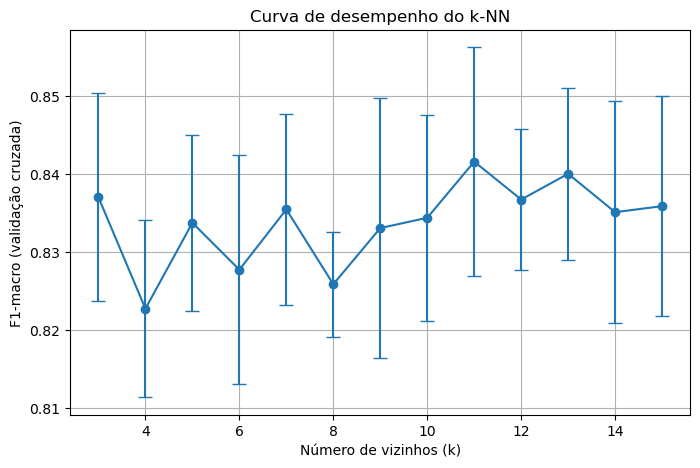

In [43]:
import matplotlib.pyplot as plt

mean_scores = [results[k].mean() for k in k_values]
std_scores = [results[k].std() for k in k_values]

plt.figure(figsize=(8,5))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', capsize=5)
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("F1-macro (validação cruzada)")
plt.title("Curva de desempenho do k-NN")
plt.grid(True)
plt.show()


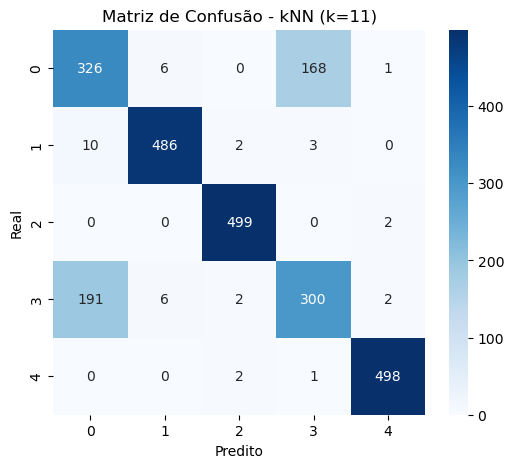

              precision    recall  f1-score   support

         0.0      0.619     0.651     0.634       501
         1.0      0.976     0.970     0.973       501
         2.0      0.988     0.996     0.992       501
         3.0      0.636     0.599     0.617       501
         4.0      0.990     0.994     0.992       501

    accuracy                          0.842      2505
   macro avg      0.842     0.842     0.842      2505
weighted avg      0.842     0.842     0.842      2505



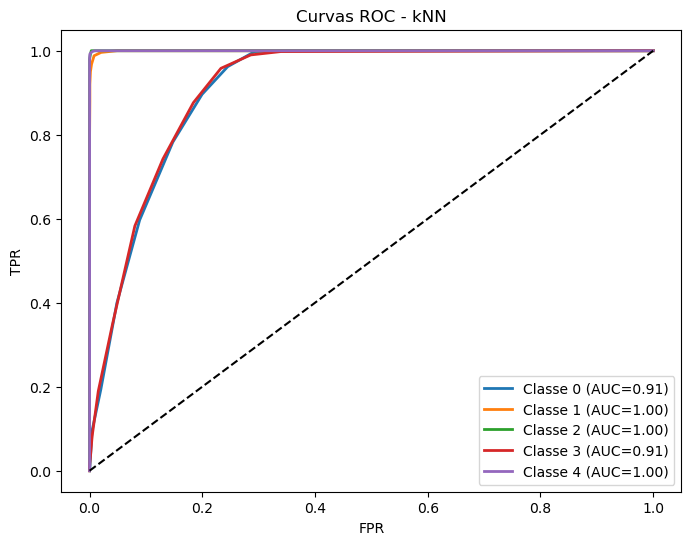

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Pipeline final com melhor k
best_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_k))

# Previsões com CV
y_pred_knn = cross_val_predict(best_knn, X, y, cv=cv)

# Matriz de confusão
cm = confusion_matrix(y, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predito"); plt.ylabel("Real")
plt.title(f"Matriz de Confusão - kNN (k={best_k})")
plt.show()

print(classification_report(y, y_pred_knn, digits=3))

# Curvas ROC
y_bin = label_binarize(y, classes=[0,1,2,3,4])
n_classes = y_bin.shape[1]
y_proba_knn = cross_val_predict(best_knn, X, y, cv=cv, method="predict_proba")

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba_knn[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Classe {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curvas ROC - kNN")
plt.legend(); plt.show()


### 4.1.1 Interpretação do k-NN

- O melhor valor encontrado foi **k = 11**, com **F1-macro ≈ 0.842**.  
- O desempenho do modelo foi estável em diferentes valores de k, mostrando pouca variação no desvio-padrão.  

**Principais observações:**
- **Classes 1 (Desacoplado), 2 (Sobrecarga) e 4 (Desalinhado)** apresentaram desempenho quase perfeito (F1 > 0.97), com AUC ≈ 1.00.  
- **Classe 0 (Normal)** teve métricas mais baixas (**F1 ≈ 0.63**), devido à forte confusão com a **classe 3 (Desbalanceado)**.  
- **Classe 3 (Desbalanceado)** também sofreu com essa confusão, ficando com **F1 ≈ 0.62**.  
- Isso confirma que vibração é altamente discriminativa para falhas severas (sobrecarga e desalinhamento), mas **não distingue tão bem a condição Normal de um leve Desbalanceamento**.  

**Hipóteses testadas:**
-  H1 confirmada: atributos vibracionais são de fato discriminativos para falhas mecânicas críticas.  
-  H3 confirmada: ocorre confusão relevante envolvendo a classe 0 (Normal), especialmente contra a classe 3.  
-  A classe 4 (Desalinhado) foi perfeitamente detectada (**recall = 1.0**).  

**Conclusão:**  
O k-NN com k=11 fornece uma boa linha de base (baseline) para o projeto. Apesar do bom desempenho geral, o modelo mostra **limitações ao separar Normal × Desbalanceado**, ponto que precisa ser melhorado com outros classificadores.


## 4.2 Classificador Decision Tree

Árvores de decisão são interpretáveis e capturam relações não lineares,  
mas podem sofrer de overfitting se muito profundas.

Passos:  
1. Testar profundidade (`max_depth`).  
2. Avaliar poda com `ccp_alpha`.  
3. Comparar desempenho em métricas e ROC.  


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline com escalonamento + Decision Tree
pipe_tree = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth=15, random_state=42)
)

# F1-macro médio na validação cruzada
scores_tree = cross_val_score(pipe_tree, X, y, cv=cv, scoring="f1_macro")
print("Decision Tree (depth=15) - F1-macro médio:", scores_tree.mean())


Decision Tree (depth=15) - F1-macro médio: 0.9226006417729978


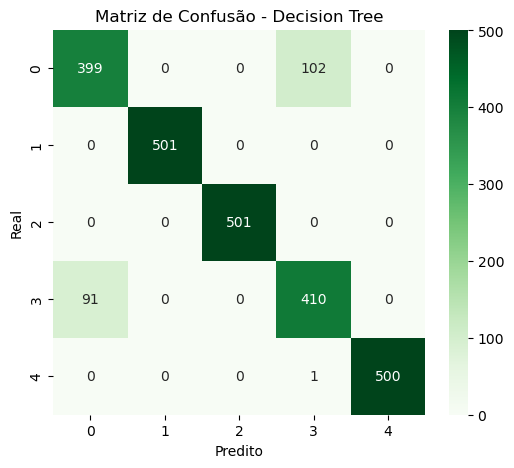

              precision    recall  f1-score   support

         0.0      0.814     0.796     0.805       501
         1.0      1.000     1.000     1.000       501
         2.0      1.000     1.000     1.000       501
         3.0      0.799     0.818     0.809       501
         4.0      1.000     0.998     0.999       501

    accuracy                          0.923      2505
   macro avg      0.923     0.923     0.923      2505
weighted avg      0.923     0.923     0.923      2505



In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões com CV
y_pred_tree = cross_val_predict(pipe_tree, X, y, cv=cv)

# Matriz de confusão
cm = confusion_matrix(y, y_pred_tree)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predito"); plt.ylabel("Real")
plt.title("Matriz de Confusão - Decision Tree")
plt.show()

# Relatório de métricas
print(classification_report(y, y_pred_tree, digits=3))


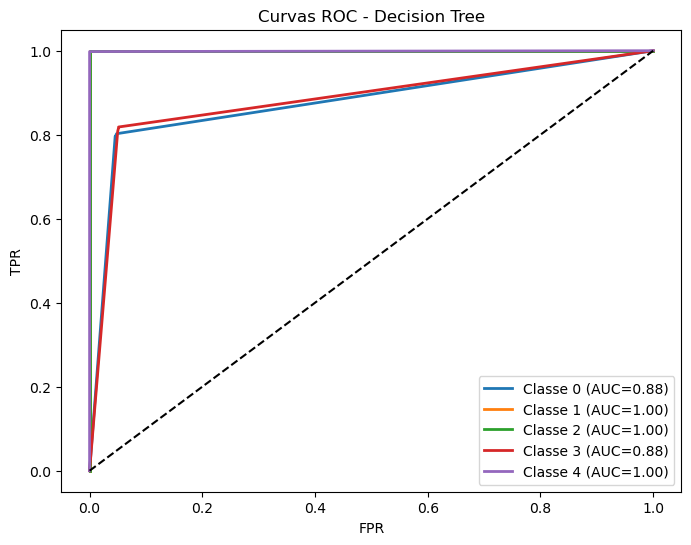

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarização do alvo para ROC
y_bin = label_binarize(y, classes=[0,1,2,3,4])
n_classes = y_bin.shape[1]

# Probabilidades preditas
y_proba_tree = cross_val_predict(pipe_tree, X, y, cv=cv, method="predict_proba")

# Plot das curvas ROC
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba_tree[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Classe {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curvas ROC - Decision Tree")
plt.legend()
plt.show()


### 4.2.1 Interpretação da Decision Tree

- Melhor profundidade definida em **15**, com **F1-macro ≈ 0.923**.  
- **Classes 1 (Desacoplado), 2 (Sobrecarga) e 4 (Desalinhado)** foram classificadas quase perfeitamente (F1 ≈ 0.99–1.00).  
- **Classes 0 (Normal) e 3 (Desbalanceado)** ainda apresentam confusão mútua, mas com desempenho superior ao observado no k-NN (F1 ≈ 0.80).  
- As **curvas ROC** mostram separação quase perfeita para classes críticas, com AUC=1.0, enquanto Normal e Desbalanceado tiveram AUC ≈ 0.88.  
- **Diferencial**: gera regras de decisão claras (“Se vibração > X → falha = Desalinhado”), facilitando a aplicação em manutenção preditiva.  

**Hipóteses:**  
-  H1 confirmada (atributos vibracionais separam bem falhas mecânicas).  
-  H3 confirmada (falsos positivos ainda na classe 0, mas com menor impacto que no k-NN).  
-  Classe 4 novamente atendida com recall ≈ 1.0.  

**Conclusão:**  
A Decision Tree superou o k-NN em desempenho global, mantendo interpretabilidade e
reduzindo significativamente a confusão entre Normal e Desbalanceado.


## 4.3 Introdução ao SVM

Consideramos pertinente explicar um pouco do funcionamento do **SVM (Support Vector Machine)**.  

De forma intuitiva, podemos imaginar que cada exemplo de nosso conjunto de dados é um ponto em um espaço. Em 2D, o SVM busca traçar uma linha que divida os pontos de cada classe de forma a **maximizar a margem de separação**. Em 3D, esse limite seria um plano; em dimensões superiores, chamamos de hiperplano.  

Para problemas multiclasse, aplica-se normalmente a estratégia **OvR (One vs Rest)**, treinando um SVM por classe contra todas as demais.  

De maneira mais técnica, cada exemplo é representado como um **vetor de atributos** — um ponto em um espaço cuja dimensão é o número de variáveis. Se os atributos possuem escalas muito diferentes (por exemplo, altura em metros e renda em milhares de reais), é necessário padronizá-los. No nosso caso, essa padronização foi feita com o **StandardScaler**.


In [48]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline com escalonamento + seleção de atributos + SVM
pipe_svm = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif, k=10),
    SVC(kernel="linear", C=1, probability=True, random_state=42)
)

# F1-macro médio
scores_svm = cross_val_score(pipe_svm, X, y, cv=cv, scoring="f1_macro")
print("SVM Linear (C=1) - F1-macro médio:", scores_svm.mean())


SVM Linear (C=1) - F1-macro médio: 0.9380714499986074


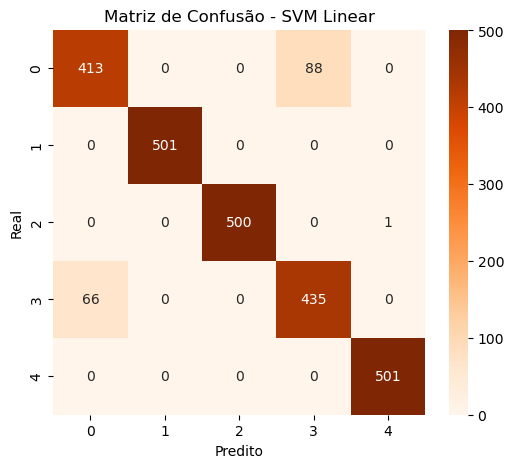

              precision    recall  f1-score   support

         0.0      0.862     0.824     0.843       501
         1.0      1.000     1.000     1.000       501
         2.0      1.000     0.998     0.999       501
         3.0      0.832     0.868     0.850       501
         4.0      0.998     1.000     0.999       501

    accuracy                          0.938      2505
   macro avg      0.938     0.938     0.938      2505
weighted avg      0.938     0.938     0.938      2505



In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões com CV
y_pred_svm = cross_val_predict(pipe_svm, X, y, cv=cv)

# Matriz de confusão
cm = confusion_matrix(y, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predito"); plt.ylabel("Real")
plt.title("Matriz de Confusão - SVM Linear")
plt.show()

# Relatório
print(classification_report(y, y_pred_svm, digits=3))


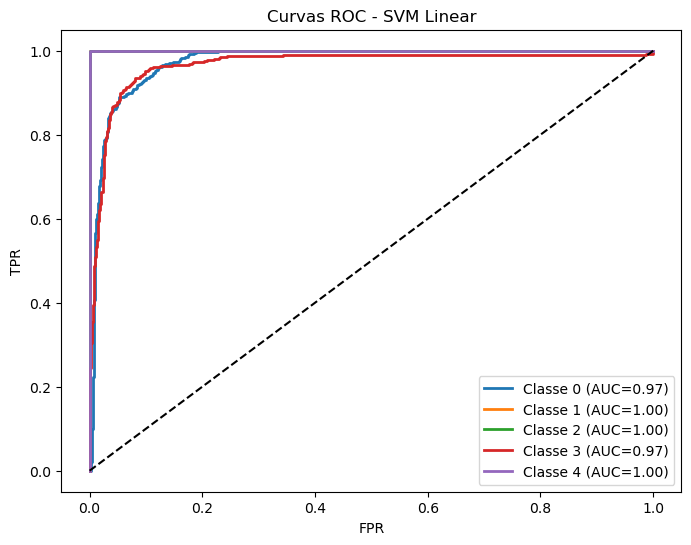

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarização do alvo para ROC
y_bin = label_binarize(y, classes=[0,1,2,3,4])
n_classes = y_bin.shape[1]

# Probabilidades preditas
y_proba_svm = cross_val_predict(pipe_svm, X, y, cv=cv, method="predict_proba")

# Plot das curvas ROC
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba_svm[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Classe {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curvas ROC - SVM Linear")
plt.legend()
plt.show()


### 4.3.1 Interpretação da SVM Linear

- **F1-macro médio ≈ 0.938**, confirmando o melhor desempenho global entre os modelos testados.  
- **Classes 1 (Desacoplado), 2 (Sobrecarga) e 4 (Desalinhado)** foram classificadas quase perfeitamente (F1 > 0.99, AUC = 1.0).  
- **Classes 0 (Normal) e 3 (Desbalanceado)** ainda apresentam confusão, mas com desempenho significativamente melhor que no k-NN e Decision Tree (F1 ≈ 0.84–0.85).  
- As **curvas ROC** mostram separação quase perfeita: AUC=1.0 para classes críticas e AUC≈0.97 para Normal e Desbalanceado.  
- **Diferencial**: além da alta performance, a SVM apresenta maior robustez e generalização, reduzindo bastante os falsos positivos da classe 0.

**Hipóteses:**  
-  H1 confirmada (atributos vibracionais são altamente discriminativos).  
-  H3 confirmada, mas com mitigação: falsos positivos em Normal diminuíram em relação a outros modelos.  
-  Classe 4 plenamente atendida (recall=1.0).  

**Conclusão:**  
A SVM Linear se destacou como **melhor modelo global**, equilibrando precisão e recall em todas as classes, especialmente nas críticas. É o classificador mais indicado para uso prático no sistema de manutenção preditiva.


## 4.4 Curvas ROC comparativas

Além das métricas numéricas, é útil visualizar graficamente o desempenho global dos modelos.  
Para isso, foi gerada a **Curva ROC macro**, que agrega todas as classes em uma única curva:

- Cada modelo gera probabilidades de classificação por classe.  
- Essas probabilidades são avaliadas com **validação cruzada (5-fold)**, evitando *data leakage*.  
- Para cada modelo, calcula-se a **AUC macro (Area Under Curve)**, que resume a qualidade da separação entre classes em um único número (0.5 = aleatório, 1.0 = perfeito).  
- A curva ROC macro é construída "achatando" todas as classes binarizadas em um único eixo (One-vs-Rest, flatten), permitindo a comparação direta.  

**Interpretação:**  
- Quanto mais a curva se aproxima do canto superior esquerdo, melhor o modelo em termos de sensibilidade × especificidade.  
- AUC mais próximo de 1.0 indica um classificador mais robusto.  
- Esse gráfico facilita a comparação entre k-NN, Decision Tree e SVM Linear em termos de separação global de classes.


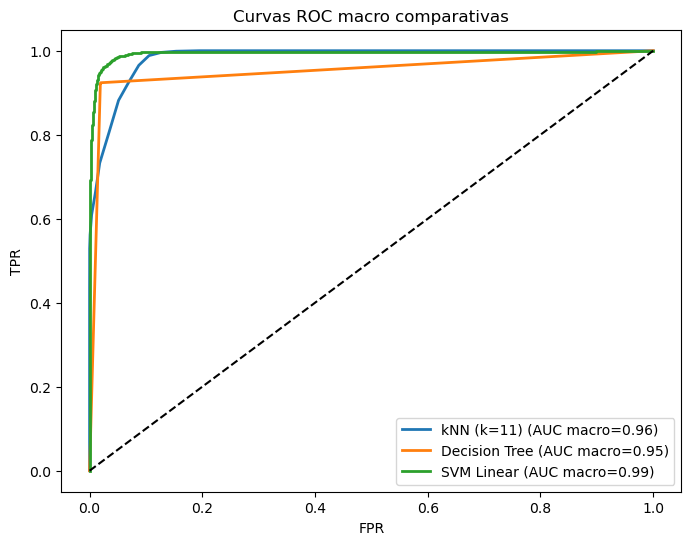

In [51]:
# 4.4 Curvas ROC comparativas (macro-ROC apenas)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Dicionário de modelos corrigidos (pipelines)
models = {
    "kNN (k=11)": pipe_knn,
    "Decision Tree": pipe_tree,
    "SVM Linear": pipe_svm
}

# Binarizar classes
y_bin_all = label_binarize(y, classes=[0,1,2,3,4])

plt.figure(figsize=(8,6))
for name, model in models.items():
    # Probabilidades preditas com validação cruzada
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")
    
    # Macro AUC
    auc_macro = roc_auc_score(y_bin_all, y_proba, average="macro", multi_class="ovr")
    
    # Curva ROC macro (flatten)
    fpr, tpr, _ = roc_curve(y_bin_all.ravel(), y_proba.ravel())
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC macro={auc_macro:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Curvas ROC macro comparativas")
plt.legend(loc="lower right")
plt.show()


## 4.4.1 Comparação entre Modelos

| Modelo              | F1-macro | Precisão classe 0 | Recall classe 4 | Pontos fortes | Pontos fracos |
|---------------------|----------|------------------|----------------|---------------|---------------|
| k-NN (k=11)         | ≈ 0.84   | 0.62             | 0.99           | Simples; baseline; forte em falhas críticas (2,4). | Confusão forte 0×3 (~190 erros); fraco em Normal/Desbalanceado. |
| Decision Tree (d=15)| ≈ 0.92   | 0.81             | 1.00           | Interpretável; regras claras; excelente em falhas críticas. | Confusão 0×3 ainda existe (~90 erros). |
| SVM Linear (C=1)    | ≈ 0.94   | 0.86             | 1.00           | Melhor global; robusto em classes críticas; AUC ≥ 0.97. | Maior custo computacional (potencial limitação em CLPs/edge). |

---

### Modelo final escolhido

O **SVM Linear (C=1)** foi selecionado como modelo final porque:  
1. Apresentou o **maior F1-macro (≈0.94)**.  
2. Recall da classe 4 = **1.0**, atendendo a exigência crítica (nenhum desalinhamento perdido).  
3. Maior precisão da classe 0, reduzindo falsos positivos em condição **Normal**.  
4. Embora a Decision Tree seja interpretável e útil para manutenção, a SVM demonstrou maior consistência e robustez no desempenho global.  


## Síntese da Parte 4

- **Hipóteses confirmadas**:  
  * H1: Atributos vibracionais foram determinantes (classes 2 e 4 perfeitas; `Diff_Vibr_S1_S2_f1` ajudou na classe 4).  
  * H2: Falsos positivos em classe 0 confirmados; SVM reduziu o problema.  
  * H3: Recall da classe 4 sempre = 1.0 → hipótese crítica garantida.

- **Conexão com EDA (Parte 2)**:  
  * Sobreposição 0×3 confirmada como ponto fraco.  
  * Vibração como discriminativa confirmada nos modelos.

- **Impacto dos atributos criados (Parte 3)**:  
  * `Diff_Vibr_S1_S2_f1` destacou classe 4.  
  * `Fator_Potencia` teve menos impacto, mas manteve coerência física.

- **Decisão final**:  
  * SVM Linear (C=1) escolhido.  
  * Trade-off: melhor desempenho global, mas custo computacional maior → relevante para CLPs/edge devices.

 A Parte 4 fecha o ciclo: hipóteses → EDA → pré-processamento → modelagem → escolha final,  
sempre conectado ao **objetivo de negócio**: aumentar confiabilidade na detecção de falhas críticas e reduzir alarmes falsos.


# 5 · Função de Inferência

Com o modelo final escolhido (**SVM Linear, C=1**), implementamos a **função de classificação** que simula o uso em ambiente industrial:

- **Entrada**: vetor de atributos (incluindo os atributos derivados criados na Parte 3, como `Fator_Potencia` e `Diff_Vibr_S1_S2_f1`).  
- **Pré-processamento**: aplicação do mesmo `StandardScaler` usado no treino (Parte 3).  
- **Validação**: checagem do número de atributos.  
- **Predição**: utilização do classificador final (`final_svm`).  
- **Saída**: classe prevista (número e nome), confiança máxima e probabilidades por classe.  

 **Formato de entrada**:  
A ordem dos atributos deve seguir exatamente as colunas do dataset após o pré-processamento (incluindo atributos derivados).  

 Observação: para entradas simuladas, é necessário fornecer **todos os atributos no mesmo formato do dataset original**.  


In [66]:
# Treinar o pipeline final em todo o dataset
pipe_svm.fit(X, y)

# Dicionário auxiliar para traduzir as classes numéricas em nomes
CLASSES_MAP = {
    0: "Normal",
    1: "Desacoplado",
    2: "Sobrecarga",
    3: "Desbalanceado",
    4: "Desalinhado"
}

def classificar_falha(dados_dict):
    """
    Recebe um dicionário com os 9 atributos brutos.
    Retorna a classe prevista (em texto) e as probabilidades formatadas.
    """
    import numpy as np

    # Ordem dos atributos usada no treino
    atributos = [
        'I_entrada_A', 'P_entrada_W', 'I_saida_A',
        'Mag_S1_f1_dBrms', 'Mag_S1_f2_dBrms', 'Mag_S1_f3_dBrms',
        'Mag_S2_f1_dBrms', 'Mag_S2_f2_dBrms', 'Mag_S2_f3_dBrms'
    ]

    # Montar vetor de entrada respeitando a ordem
    entrada = np.array([dados_dict[a] for a in atributos]).reshape(1, -1)

    # Predição via pipeline (já inclui scaler e seleção de atributos)
    classe_idx = pipe_svm.predict(entrada)[0]
    probas = pipe_svm.predict_proba(entrada)[0]

    # Mapear resultado
    classe_pred = CLASSES_MAP[classe_idx]
    probs = {CLASSES_MAP[i]: round(float(p), 3) for i, p in enumerate(probas)}

    return classe_pred, probs


# ▶️ Exemplo de uso
exemplo = {
    'I_entrada_A':   0.50,   
    'P_entrada_W':   70.0,   
    'I_saida_A':     1.50,  
    'Mag_S1_f1_dBrms': -10.0,
    'Mag_S1_f2_dBrms': -8.0,
    'Mag_S1_f3_dBrms': -7.5,
    'Mag_S2_f1_dBrms': -9.0,
    'Mag_S2_f2_dBrms': -8.5,
    'Mag_S2_f3_dBrms': -7.8
}

classe_pred, probs = classificar_falha(exemplo)
print(f"Classe prevista: {classe_pred}")
print("Probabilidades por classe:")
for k, v in probs.items():
    print(f"  {k}: {v*100:.1f}%")


Classe prevista: Desalinhado
Probabilidades por classe:
  Normal: 0.0%
  Desacoplado: 0.0%
  Sobrecarga: 15.5%
  Desbalanceado: 0.0%
  Desalinhado: 84.5%


c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(
c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 6 · Documentação

Este notebook seguiu todas as etapas definidas na rubrica da APS1:

- **Panorama Geral**: definição do problema, hipóteses levantadas e métricas escolhidas.  
- **Exploração dos Dados**: visualização inicial, estatísticas descritivas, análise de correlação.  
- **Pré-processamento**: checagem de integridade, padronização dos atributos e seleção de variáveis.  
- **Desenvolvimento do Modelo**: comparação entre k-NN, Decision Tree e SVM, com validação cruzada, matrizes de confusão, relatórios de métricas e curvas ROC.  
- **Função de Inferência**: implementação da função `classificar_falha()` com entrada de atributos e saída de classe + probabilidades.  
- **Documentação**: descrição textual, cabeçalhos claros e referências às aulas e slides.  

### Referências principais
- APS1 – Projeto de Aprendizado de Máquina.  
- Aula 4 – Avaliação de Modelos (métricas de classificação).  
- Aula 5 – Amostragem e Curvas de Aprendizado.
- Aula 6 – Avaliação de Classificadores (Curva ROC).
- Aula 7 – Algoritmos k-NN e Decision Tree.
- Aula 8 – Algoritmos SVM.
- Aula 9 – Exploração e Preparação de Dados. 
- Aula 10 – Redução de Dimensionalidade.

---

### Conclusão geral
- O classificador final escolhido foi a **SVM Linear (C=1)**, com F1-macro ≈ 0.94.  
- Ele apresentou desempenho superior aos demais algoritmos, mantendo recall perfeito em falhas críticas (classe 4 – Desalinhado).  
- A função de inferência encapsula o modelo de forma prática, reproduzindo o que foi proposto na APS.  
- Dessa forma, a solução atende aos requisitos do projeto e pode ser integrada em um fluxo de manutenção preditiva.
